In [4]:
from numpy import sin, cos, linalg, array
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import warnings

In [7]:
class Pendulum:

    def __init__(self, Δx, θ_0, ω_0, r = 0.0075):
        self.ℓ = 0.1
        self.g = 9.8
        self.θ = [θ_0]
        self.ω = [ω_0]
        self.r = r
        self.Δx = Δx

    # Returns the gradient of theta (omega)
    def θGrad(self, θ, ω):
        return ω

    # Returns the gradient of omega (omega')
    def ωGrad(self, θ, ω):
        return -1*self.g/self.ℓ*sin(θ)
        
    # Update theta and omega for timestep delta, according to the Euler method.

    def IntegrateStep(self, delta):
        """
        Append new theta and omega states to the internal lists, which result from
        the time step delta. Integration done via the Runge–Kutta Method.
        """
        j, k = {}, {}
      
        j[0] = k[0] = 0

        for i in [1, 2, 3, 4]:
            h = delta/2 if i == 2 or i == 3 else delta

            for (var, func) in [(j, self.θGrad),(k, self.ωGrad)]:
                
                var[i] = func(self.θ[-1] + h*var[i-1], self.ω[-1] + h*var[i-1])
        
        for (var, state) in [(j, self.θ), (k, self.ω)]:
            
            state.append(state[-1] + h/6*(var[1] + 2*var[2] + 2*var[3] + var[4]))
    
        return
    
    
    def Transform(self, θ):
        return (self.ℓ*sin(θ)+self.Δx, -self.ℓ*cos(θ))
    
    def MakeArtists(self):
        (x, y) = self.Transform(self.θ[-1])
        
        mass = plt.Circle((x, y), radius=self.r , color='k')
        
        string, = plt.plot([self.Δx, x], [0, y], '-', color='k')
        
        return [mass, string]
    
class Cradle:
    
    def __init__(self, pendParams):
        self.pendulums = self.InitialisePends(pendParams)
        
    def InitialisePends(self, pendParams):
        pendulums = []
        
        for (Δx, θ_0, ω_0) in pendParams:
            pendulums.append(Pendulum(Δx, θ_0, ω_0))

        return pendulums
    
    def HasCollided(self, pen1, pen2):
        pen1_loc = array(pen1.Transform(pen1.θ[-1]))
        pen2_loc = array(pen2.Transform(pen2.θ[-1]))
        if linalg.norm(pen1_loc - pen2_loc) <= pen1.r + pen2.r:
            if linalg.norm(pen1_loc - pen2_loc) <= 0.95*(pen1.r+pen2.r):
                raise ValueError("Collision detected late, consider using a smaller time step!")
            return True
    
    def ElectrostaticRepulsion(self):
        for (pen1, pen2) in itertools.combinations(self.pendulums, 2):
            if self.HasCollided(pen1, pen2):
                temp_ω = pen1.ω[-1]
                pen1.ω[-1] = pen2.ω[-1]
                pen2.ω[-1] = temp_ω
                ### need to send them off in the other direction.
    

In [5]:
from matplotlib import rcParams, rc
from IPython.display import HTML
##Warning this code requires a working latex installation to execute and ffmpeg

rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (16/2,9/2)

In [45]:
from matplotlib import animation
from IPython.display import HTML
from numpy import arange


def plot_physics(timeinterval, pendParams):
    t_step = 0.00001
    t_domain = arange(0, timeinterval, t_step)
    last_frame = 0
    frame_length = 1/60
    
    cradle = Cradle(pendParams)
    
    fig = plt.figure()
    plt.axis('off')
    ax = fig.add_subplot(111)
    ax.set_aspect(aspect=1)

    plt.ylim((-0.12, 0.02))
    plt.xlim((-.05, 0.15))

    ## initialise environment
    
    object_instances = []
    
    last_collision = 0
    
    for t in t_domain:
        if t - last_collision > t_step:
            cradle.ElectrostaticRepulsion()
            last_collision = t
        
        for pend in cradle.pendulums:
            pend.IntegrateStep(t_step)
        
        if t - last_frame >= frame_length:
            objects = []
            for pend in cradle.pendulums:
                (mass, string) = pend.MakeArtists()
                objects.append(string)
                objects.append(ax.add_patch(mass))
            object_instances.append(objects)
            last_frame = t
    
    ani = animation.ArtistAnimation(fig, object_instances, interval=frame_length*1000*2)

    return HTML(ani.to_html5_video())

<ipython-input-45-4d2a6bb00400>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


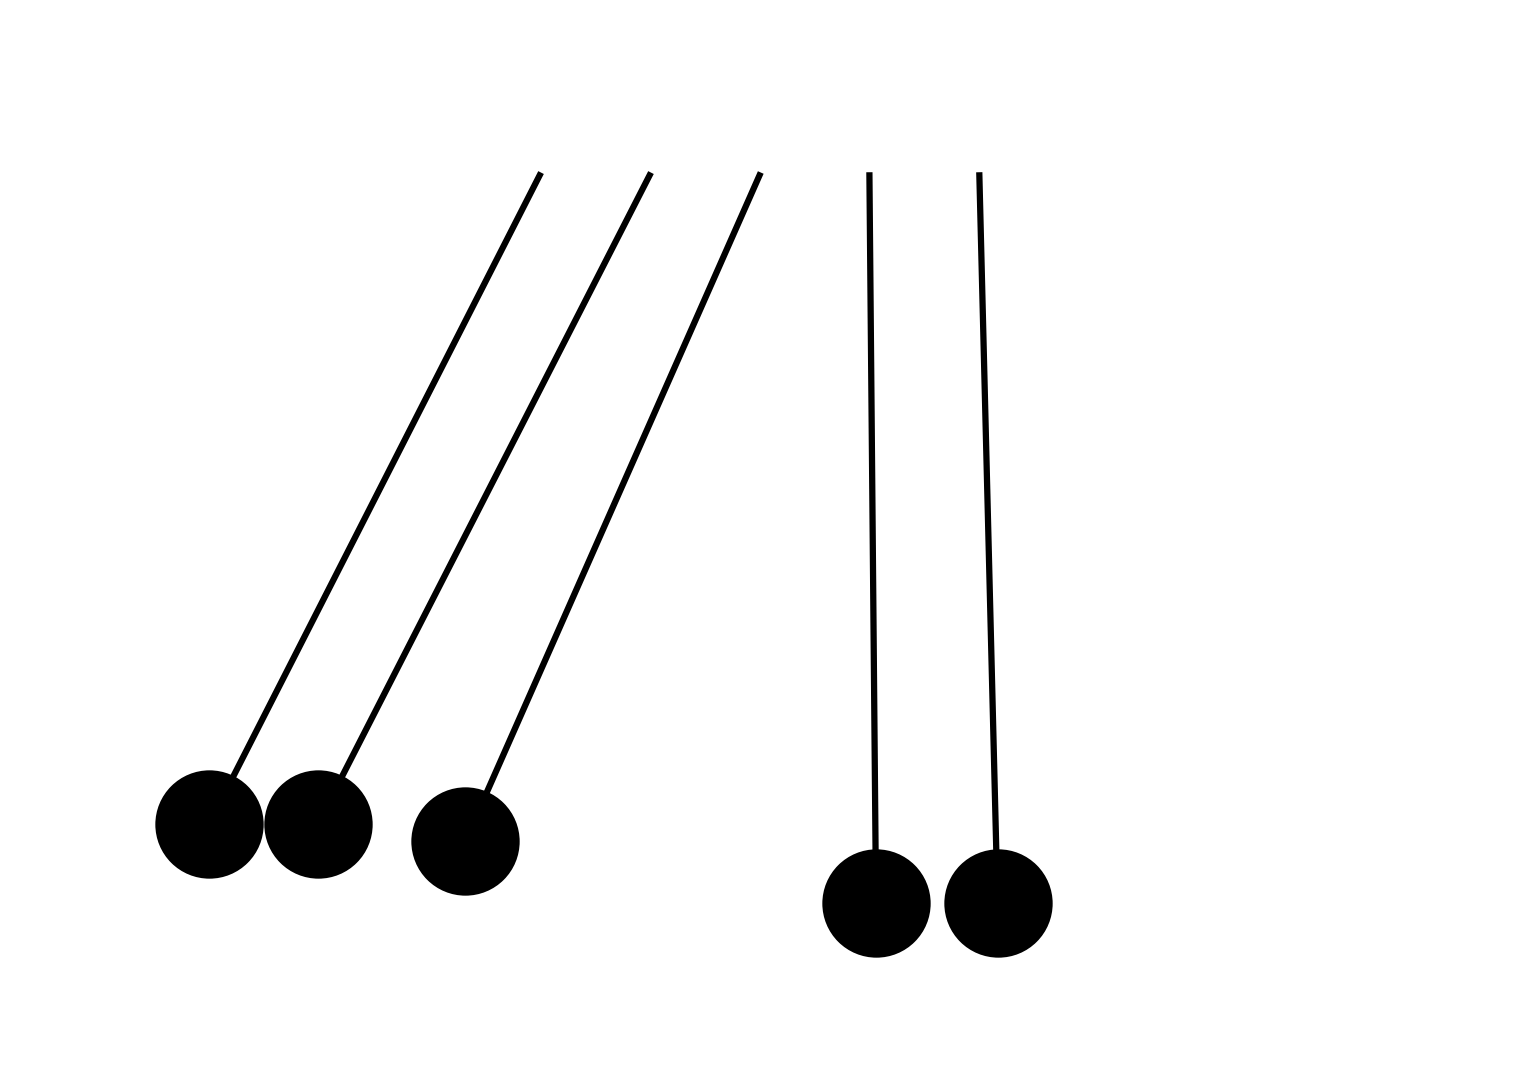

In [46]:
pendParams = [(0+0.02, 0, 0),
              (0.0151+0.02, 0, 0),
              (0.0302+.02, 0.5, 0),
              (0.0453+0.02, 0.5, 0),
              (0.0604+0.02, 0.5, 0)]

plot_physics(10, pendParams)

<ipython-input-41-08d892b496f3>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2400x1350', '-pix_fmt', 'rgba', '-r', '29.999999999999996', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp7ly9v5r2/temp.m4v']' returned non-zero exit status 255.

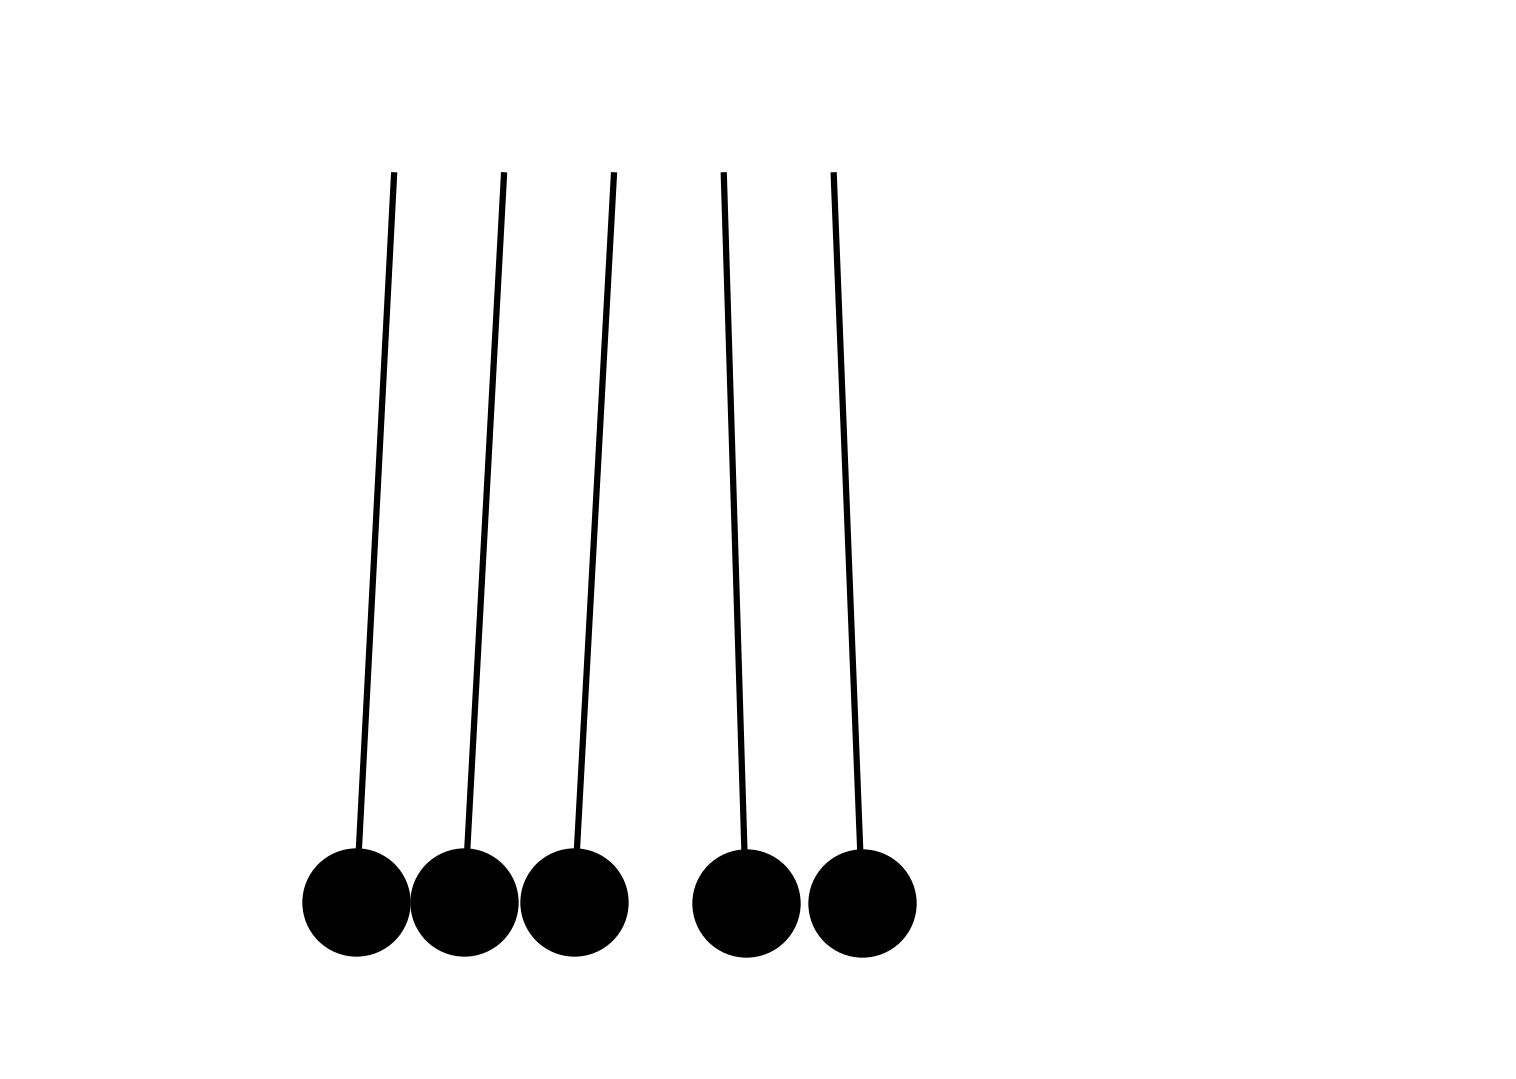

In [43]:
pendParams = [(0, 0, 0),
              (0.0151, 0, 0),
              (0.0302, 0, 0),
              (0.0453, 0.5, 0),
              (0.0604, 0.5, 0)]

plot_physics(10, pendParams)

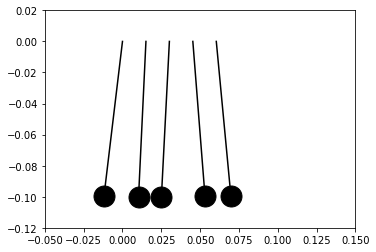

In [16]:
pendParams = [(0, 0, 0),
              (0.0151, 0, 0),
              (0.0302, 0.5, 0),
              (0.0453, 0.5, 0),
              (0.0604, 0.5, 0)]

plot_physics(5, pendParams)

Today I achieved the milestones in the plan;

 - Use the single pendulum class as a starting point, use it to replicate the lab results in ```matplotlib```
 - Create a ``matplotlib`` objects to draw the system 
 - (2)
 - Add two pendulums swinging simultaneously on the same plot

With too larger timestep used in the integration method, the system diverges from real behavior and it gains energy. With my initial method I was plotting the objects each time the ```IntegrateStep``` method was called - this resulted in long computation times. For smooth motion to appear to a human, we only need to plot 60 frames per second or so. So I have decided to call ```MakeArtists``` only once every 1/60 simulated seconds to achieve this - this significantly reduces computation time.

In [165]:
linalg.norm((1,1))

1.4142135623730951

In [193]:
from numpy import array

In [276]:
array((-0.01993987, -0.09799185)) - array((-0.00493987, -0.09799185))

array([-0.015,  0.   ])

Im having the problem that sometimes the spheres get stuck inside one another. I've added an exception to be raised if the collision is detected within the first 5% of the sphere's radii - this causes the code to abort immediately.


I noticed that the internal pendulums begin to move after some time. This occurs during a real newton's cradle too. It happens if any of the pendlumus collide with an angle non-paralell to the vertical ($\theta != 0$ ). If this ever occurs, the pendulums will begin to be accelerated by gravity - when the pendulum collides again this will result in a runaway postitive feedback loop.